# Genetic algorithm to fit a cosmological model with Union2 supernova data

We use the AG to optimize the Chi-Square statistic with the model:

\begin{equation*}
E(z) = \sqrt{\Omega_m (1 + z)^3 + (1 - \Omega_m)e^{3w_1 z}(1 + z)^{ 1 + w_0 - w_1}}
\end{equation*}

taking $\Omega_m $, $w_0$ and $w_1$ as variables. From this perspective, the optimization is unconstrained.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
from scipy.integrate import quad

# Importamos libreria de algoritmos evolutivos 

from deap import base, creator, tools, algorithms

# importamos modulo independiente para acoplar a DEAP, adjunto en la carpeta fuente. 

import elitism

# We import an independent module to implement elitism in the GA.

import random

In [19]:
# We load the observational data of the Supernovae, the file must be attached in the source folder.

z_obs, m_obs, dm_obs_stat = np.loadtxt("sn_z_mu_dmu_union2.dat", unpack=True)

dm_obs = dm_obs_stat

In [178]:
def luminosity_integrand(z, omgM, w_0 =-1, w_1=0):
    #Ez = np.sqrt(omgM * np.power(1 + z, 3) + (1 - omgM)*np.exp(3*w_1*z)*np.power(1 + z, 1 + w_0 - w_1))
    Ez = np.sqrt(omgM*(1 + z)** 3 + (1-omgM)*(1+z)**(3*(1+w_0+w_1))*np.exp(-3*w_1*z/(1+z)))
    return 1. / Ez

def luminosity_distance(z, omgM, w_0=-1, w_1=0):
    h=0.72
    integral, _ = quad(luminosity_integrand, 0, z, epsrel=1e-8, args=(omgM, w_0, w_1))
    return (cte.c / 10. ** 5) / h * (1 + z) * integral

def distance_modulus(z, omgM, w_0=-1, w_1=0):
    return 5. * np.log10(luminosity_distance(z, omgM, w_0, w_1)) + 25.

In [179]:
# # We define the marginalized Chi-Square.

def X(omgM, w_0, w_1):
    m_model = np.array([distance_modulus(z, omgM, w_0, w_1) for z in z_obs])
    X_vec = np.power(((m_model - m_obs) / dm_obs), 2)
    return X_vec.sum()

def Y(omgM, w_0, w_1):
    m_model = np.array([distance_modulus(z, omgM, w_0, w_1) for z in z_obs])
    Y_vec = (m_model - m_obs) / dm_obs**2
    return Y_vec.sum()

def Z(omgM, w_0, w_1):
    m_model = np.array([distance_modulus(z, omgM, w_0, w_1) for z in z_obs])
    Z_vec = 1.0/dm_obs**2
    return Z_vec.sum()

def chisq(individual):
    omgM = individual[0]
    w_0 = -2 + (0+2)*individual[1]
    w_1 = -2 + (2+2)*individual[2]
    
    m_model = np.array([distance_modulus(z, omgM, w_0, w_1) for z in z_obs])
    chisq_vec = X(omgM, w_0, w_1) - Y(omgM, w_0, w_1)**2/Z(omgM, w_0, w_1) + np.log10(Z(omgM, w_0, w_1)/2*np.pi)
    f=chisq_vec.sum()
    return f,

In [180]:
# problem constants:
DIMENSIONS = 3  # number of dimensions
BOUND_LOW, BOUND_UP = 0.0, 1.0  # boundaries for all dimensions

In [220]:
# Genetic Algorithm constants:
POPULATION_SIZE = 20  # 10-20
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.3   # (try also 0.5) probability for mutating an individual
MAX_GENERATIONS = 15  # 100- 300
HALL_OF_FAME_SIZE = 1
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

In [221]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [222]:
toolbox = base.Toolbox()

In [223]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

/usr/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [224]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [225]:
# helper function for creating random real numbers uniformly distributed within a given range [low, up]
# it assumes that the range is the same for every dimension
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

In [226]:
# create an operator that randomly returns a float in the desired range and dimension:
toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

In [227]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)

In [228]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [229]:
toolbox.register("evaluate", chisq)

In [230]:
# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, 
                 eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)

In [231]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with elitism:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    print("chisq / dof = ", best.fitness.values[0] / (len(z_obs) - 1))


    print("- Best solutions are:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

    # extract statistics:
    # minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")

    return population, logbook, hof

gen	nevals	min    	avg    
0  	20    	598.375	908.514
1  	15    	557.645	734.309
2  	17    	553.756	696.048
3  	15    	553.756	634.759
4  	13    	548.845	573.979
5  	19    	548.838	553.932
6  	14    	548.102	551.219
7  	11    	548.102	550.773
8  	17    	547.647	553.98 
9  	13    	546.827	548.601
10 	17    	546.737	548.779
11 	14    	546.737	551.027
12 	15    	546.737	549.457
13 	14    	546.737	556.779
14 	15    	546.737	556.787
15 	12    	546.737	546.779
-- Best Individual =  [0.3373748351872161, 0.4566927593235745, 0.286722622754574]
-- Best Fitness =  546.7370732420246
chisq / dof =  0.983340059787814
- Best solutions are:
0 :  546.7370732420246  ->  [0.3373748351872161, 0.4566927593235745, 0.286722622754574]


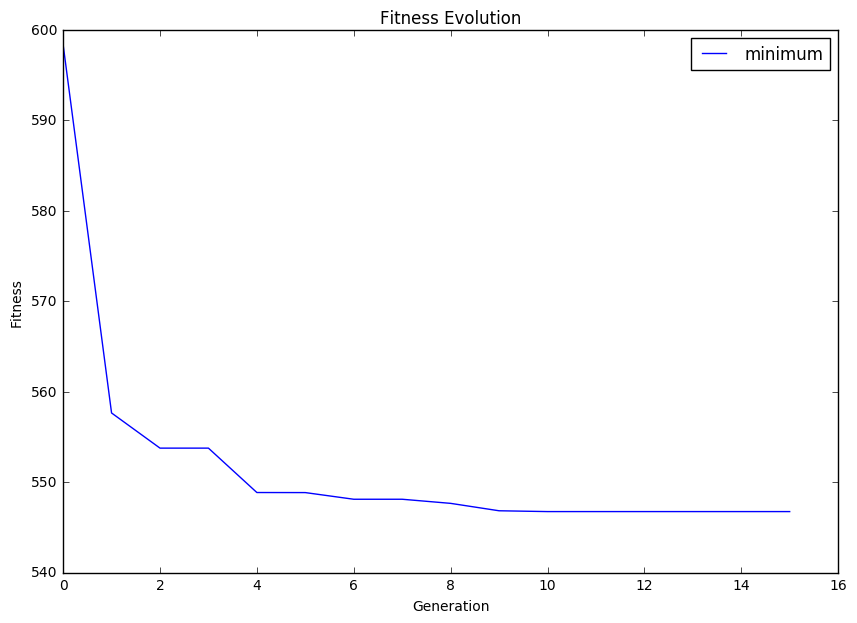

In [232]:
pop, log, hof = main()

gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")

plt.figure(figsize=(10, 7))
#plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
#plt.plot(gen, max_, label="maximum")
plt.title("Fitness Evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
#plt.savefig('GA_wwCDM_150.png')
plt.show()

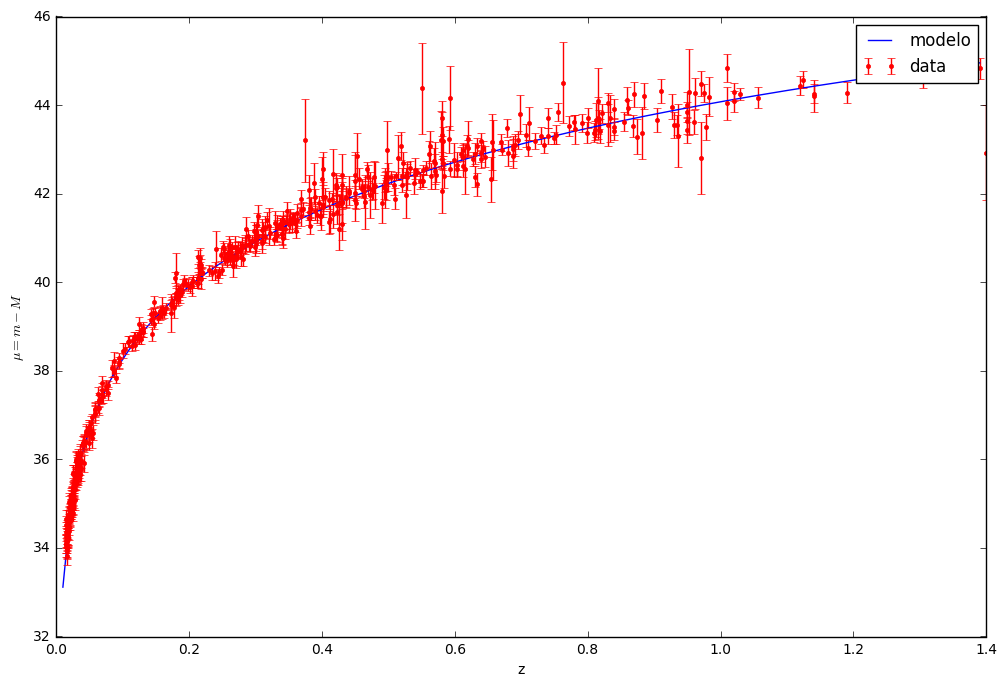

In [235]:
# Plots
zs = np.arange(0.01, 1.4, 0.01)
#distance_modulus_best_omgM1 = np.vectorize(lambda z : distance_modulus(z, omgM_best))
distance_modulus_best_omgM2 = np.vectorize(lambda z : distance_modulus(z, 
                                                0.337, -2 + (0+2)*0.456, -2 + (2+2)*0.286))
                                                        
    #0.08571778579456588, 3.425063539542368e-10, 1.097548098861026e-09))
#distance_modulus_best_omgM22 = np.vectorize(lambda z : distance_modulus(z, 
#                                                0,0,0))
plt.figure(figsize=(12, 8))
plt.xlabel("z")
plt.ylabel(r"$\mu = m - M$")
#plt.plot(zs, distance_modulus_best_omgM1(zs), label=b"modelo $h$")
plt.plot(zs, distance_modulus_best_omgM2(zs), label="modelo")
#plt.plot(zs, distance_modulus_best_omgM22(zs), label="modelo")
plt.errorbar(z_obs, m_obs, dm_obs, fmt='r.', label=r"data")
plt.legend();
plt.show()
#plt.savefig('resultado_1.png')